In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv('dataset_for_SI_clean.csv')

df.head()


,SI,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,log_IC50,log_CC50
0,7.00,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,0.012887,-0.313407,0.607143,...,0,0,0,0,0,0,3,0,0.572014,1.856738
1,0.72,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,0.094802,-0.325573,0.562500,...,0,0,0,0,0,0,3,0,5.415250,5.088474
2,1.30,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,0.062897,-0.257239,0.600000,...,0,0,0,0,0,0,0,0,4.683348,4.943576
3,2.00,5.758408,0.278083,0.278083,0.711012,28.600000,332.491,0.062897,-0.398729,0.960000,...,0,0,0,0,0,0,0,0,2.774955,3.436430
4,0.77,2.584472,0.429649,0.429649,0.328539,36.564103,528.869,0.132160,-0.293073,0.564103,...,0,0,0,0,0,0,0,0,2.991130,2.744658


In [14]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


Удаляем из датасета утечки: ['log_IC50']
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
RF (no leak): RMSE=5.024, R2=0.068, MAE=3.671
CatBoost (no leak): RMSE=4.998, R2=0.077, MAE=3.795


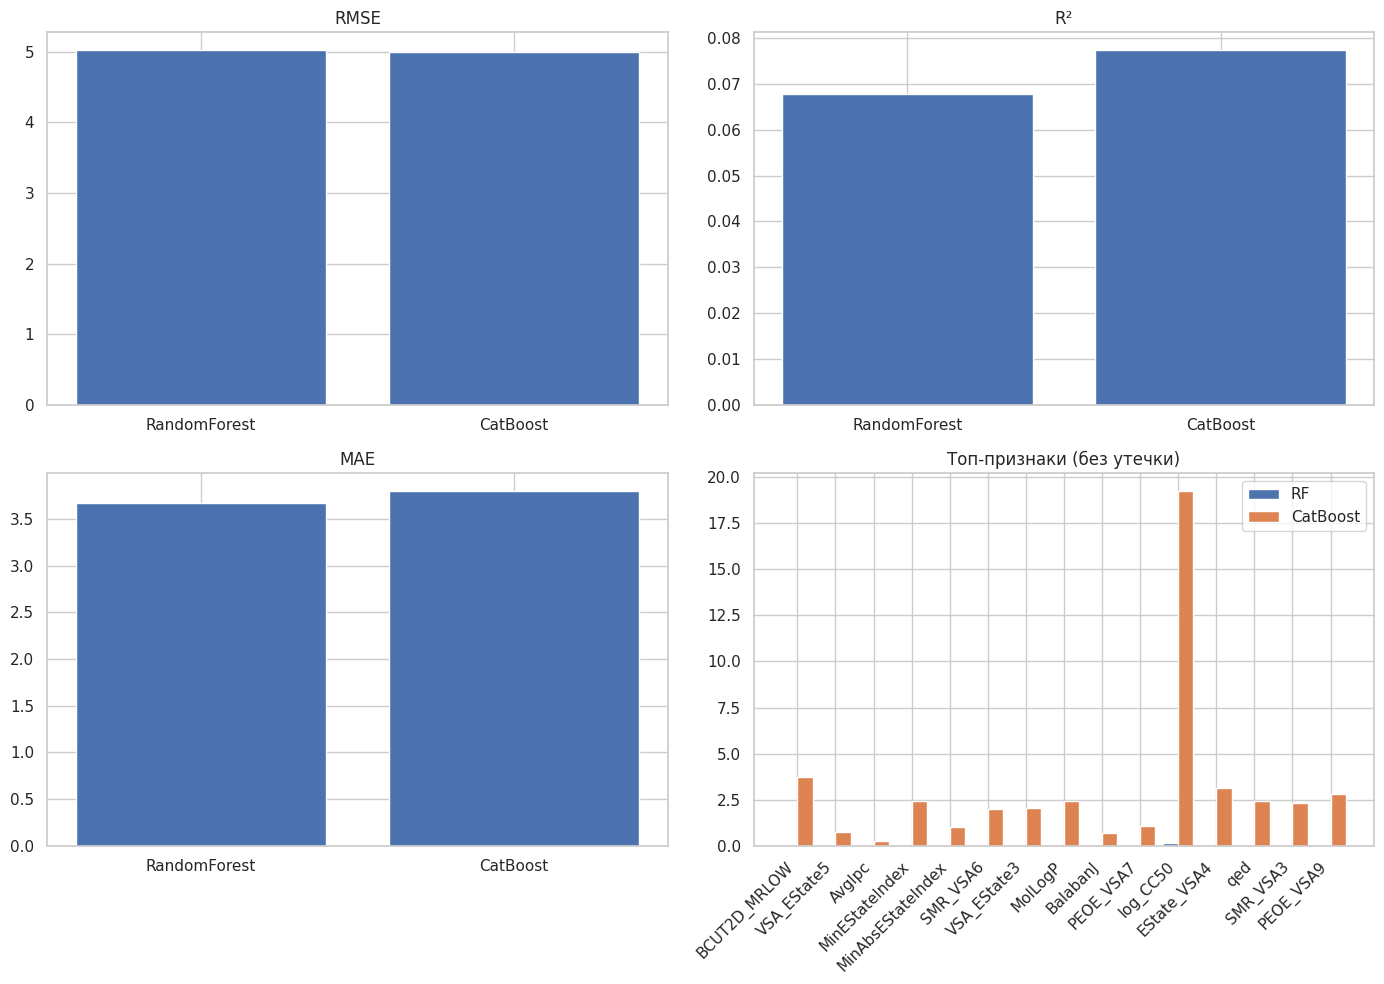

In [22]:

!pip install catboost --quiet

# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# удаление «утечки»
df = pd.read_csv('/content/dataset_for_SI_clean.csv')
# с IC50/CS50 (в любом регистре):
leak_cols = [c for c in df.columns if 'IC50' in c.upper() or 'CS50' in c.upper()]
print("Удаляем из датасета утечки:", leak_cols)

X = df.drop(columns= ['SI'] + leak_cols, errors='ignore')
y = df['SI']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# RandomForest (RandomizedSearchCV)
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_jobs=-1, random_state=42))
])
param_dist_rf = {
    'model__n_estimators':      [100, 200, 300],
    'model__max_depth':         [10, 20, None],
    'model__min_samples_split': [2, 5]
}
rs_rf = RandomizedSearchCV(
    pipe_rf, param_distributions=param_dist_rf,
    n_iter=6, cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, verbose=2, random_state=42
)
rs_rf.fit(X_train, y_train)

#CatBoost (RandomizedSearchCV + early stopping)
pipe_cb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(
        verbose=False, random_state=42, early_stopping_rounds=20
    ))
])
param_dist_cb = {
    'model__iterations':     [100, 200],
    'model__depth':          [4, 6],
    'model__learning_rate':  [0.1, 0.01]
}
rs_cb = RandomizedSearchCV(
    pipe_cb, param_distributions=param_dist_cb,
    n_iter=4, cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, verbose=2, random_state=42
)
rs_cb.fit(X_train, y_train)

#  Оценка
def eval_model(name, model):
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    r2   = r2_score(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    print(f"{name}: RMSE={rmse:.3f}, R2={r2:.3f}, MAE={mae:.3f}")

eval_model("RF (no leak)", rs_rf)
eval_model("CatBoost (no leak)", rs_cb)

# 2×2 с важностями признаков
rf_pipeline = rs_rf.best_estimator_
cb_pipeline = rs_cb.best_estimator_

y_pred_rf = rf_pipeline.predict(X_test)
y_pred_cb = cb_pipeline.predict(X_test)

models = ['RandomForest', 'CatBoost']
rmse = [
    np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    np.sqrt(mean_squared_error(y_test, y_pred_cb))
]
r2   = [
    r2_score(y_test, y_pred_rf),
    r2_score(y_test, y_pred_cb)
]
mae  = [
    mean_absolute_error(y_test, y_pred_rf),
    mean_absolute_error(y_test, y_pred_cb)
]

feat_names = X_train.columns.to_list()
imp_rf = rf_pipeline.named_steps['model'].feature_importances_
imp_cb = cb_pipeline.named_steps['model'].feature_importances_

# топ-10 признаков по обеим моделям
top_idx_rf = np.argsort(imp_rf)[::-1][:10]
top_idx_cb = np.argsort(imp_cb)[::-1][:10]
top_feats = list({feat_names[i] for i in np.concatenate([top_idx_rf, top_idx_cb])})
imp_rf_top = [imp_rf[feat_names.index(f)] for f in top_feats]
imp_cb_top = [imp_cb[feat_names.index(f)] for f in top_feats]

fig, axes = plt.subplots(2, 2, figsize=(14,10))

axes[0,0].bar(models, rmse);  axes[0,0].set_title('RMSE')
axes[0,1].bar(models, r2);    axes[0,1].set_title('R²')
axes[1,0].bar(models, mae);   axes[1,0].set_title('MAE')

x = np.arange(len(top_feats)); w=0.4
axes[1,1].bar(x-w/2, imp_rf_top, w, label='RF')
axes[1,1].bar(x+w/2, imp_cb_top, w, label='CatBoost')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(top_feats, rotation=45, ha='right')
axes[1,1].set_title('Топ-признаки (без утечки)')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [24]:
# Устанавливаем xgboost
!pip install xgboost --quiet

# Импорты
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# удаление утечки
df = pd.read_csv('/content/dataset_for_SI_clean.csv')
leak_cols = [c for c in df.columns if 'IC50' in c.upper() or 'CS50' in c.upper()]
print("Удаляем утечки:", leak_cols)
X = df.drop(columns=['SI'] + leak_cols, errors='ignore')
y = df['SI']

# Сплит
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#  Pipeline 1: RF + SelectKBest(10)
pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest(f_regression, k=10)),
    ('rf', RandomForestRegressor(
        n_estimators=200, max_depth=15, random_state=42, n_jobs=-1
    ))
])
pipe_rf.fit(X_train, y_train)

# Pipeline 2: XGBoost (дефолтно)
pipe_xgb = Pipeline([
    ('scale', StandardScaler()),
    ('xgb', XGBRegressor(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        random_state=42, verbosity=0
    ))
])
pipe_xgb.fit(X_train, y_train)

# Предсказания и ансамбль
pred_rf  = pipe_rf.predict(X_test)
pred_xgb = pipe_xgb.predict(X_test)
pred_ens = (pred_rf + pred_xgb) / 2

# Исправленная функция метрик
def eval_model(name, y_pred):
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    print(f"{name:20s} RMSE={rmse:.3f}, R2={r2:.3f}, MAE={mae:.3f}")

# Итоги
eval_model("RF SelectKBest",  pred_rf)
eval_model("XGBoost",        pred_xgb)
eval_model("Ensemble (avg)", pred_ens)



Удаляем утечки: ['log_IC50']
RF SelectKBest       RMSE=5.091, R2=0.043, MAE=3.788
XGBoost              RMSE=5.238, R2=-0.013, MAE=3.762
Ensemble (avg)       RMSE=5.037, R2=0.063, MAE=3.721


Удаляем утечки: ['log_IC50']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7617
[LightGBM] [Info] Number of data points in the train set: 508, number of used features: 116
[LightGBM] [Info] Start training from score 5.465605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


RF SelectKBest            RMSE=5.091, R2=0.043, MAE=3.788
RF + Poly + SelectK       RMSE=5.232, R2=-0.011, MAE=3.921
XGBoost                   RMSE=5.238, R2=-0.013, MAE=3.762
LightGBM                  RMSE=5.352, R2=-0.058, MAE=3.894
Stacking (RF+XGB)         RMSE=4.970, R2=0.088, MAE=3.781
RF без выбросов y         RMSE=5.175, R2=0.011, MAE=3.809


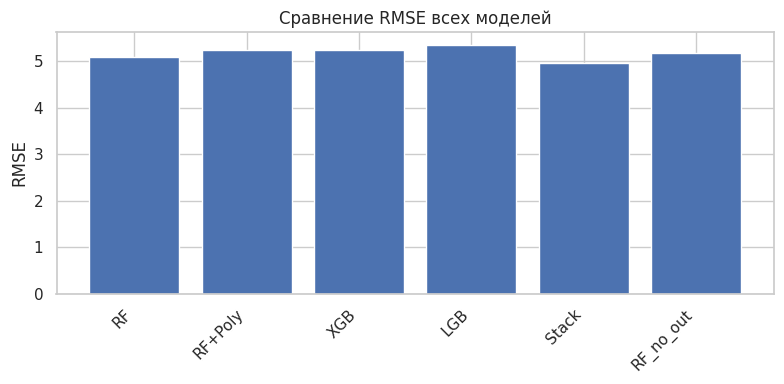

In [25]:

!pip install xgboost lightgbm --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


df = pd.read_csv('/content/dataset_for_SI_clean.csv')
leak_cols = [c for c in df.columns if 'IC50' in c.upper() or 'CS50' in c.upper()]
print("Удаляем утечки:", leak_cols)
X = df.drop(columns=['SI'] + leak_cols, errors='ignore')
y = df['SI']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Базовый RF + SelectKBest
pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest(f_regression, k=10)),
    ('rf', RandomForestRegressor(
        n_estimators=200, max_depth=15, random_state=42, n_jobs=-1
    ))
])
pipe_rf.fit(X_train, y_train)

# RF с PolynomialFeatures
pipe_rf_poly = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('select', SelectKBest(f_regression, k=10)),
    ('rf', RandomForestRegressor(
        n_estimators=200, max_depth=15, random_state=42, n_jobs=-1
    ))
])
pipe_rf_poly.fit(X_train, y_train)

# XGBoost
pipe_xgb = Pipeline([
    ('scale', StandardScaler()),
    ('xgb', XGBRegressor(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        random_state=42, verbosity=0
    ))
])
pipe_xgb.fit(X_train, y_train)

# LightGBM
pipe_lgb = Pipeline([
    ('scale', StandardScaler()),
    ('lgb', LGBMRegressor(random_state=42, n_jobs=-1))
])
pipe_lgb.fit(X_train, y_train)


# Stacking RF + XGB
estimators = [
    ('rf', pipe_rf),
    ('xgb', pipe_xgb)
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1
)
stack.fit(X_train, y_train)

# Удаление выбросов в y (топ/низ 1%) и переобучение RF
mask = y_train.between(y_train.quantile(0.01), y_train.quantile(0.99))
X_tr2, y_tr2 = X_train[mask], y_train[mask]
pipe_rf_no_out = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest(f_regression, k=10)),
    ('rf', RandomForestRegressor(
        n_estimators=200, max_depth=15, random_state=42, n_jobs=-1
    ))
])
pipe_rf_no_out.fit(X_tr2, y_tr2)
def eval_model(name, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    print(f"{name:25s} RMSE={rmse:.3f}, R2={r2:.3f}, MAE={mae:.3f}")

pred_rf         = pipe_rf.predict(X_test)
pred_rf_poly    = pipe_rf_poly.predict(X_test)
pred_xgb        = pipe_xgb.predict(X_test)
pred_lgb        = pipe_lgb.predict(X_test)
pred_stack      = stack.predict(X_test)
pred_rf_no_out  = pipe_rf_no_out.predict(X_test)

eval_model("RF SelectKBest",       pred_rf)
eval_model("RF + Poly + SelectK",  pred_rf_poly)
eval_model("XGBoost",              pred_xgb)
eval_model("LightGBM",             pred_lgb)
eval_model("Stacking (RF+XGB)",    pred_stack)
eval_model("RF без выбросов y",    pred_rf_no_out)

names = ["RF", "RF+Poly", "XGB", "LGB", "Stack", "RF_no_out"]
rmses = [
    np.sqrt(mean_squared_error(y_test, pred_rf)),
    np.sqrt(mean_squared_error(y_test, pred_rf_poly)),
    np.sqrt(mean_squared_error(y_test, pred_xgb)),
    np.sqrt(mean_squared_error(y_test, pred_lgb)),
    np.sqrt(mean_squared_error(y_test, pred_stack)),
    np.sqrt(mean_squared_error(y_test, pred_rf_no_out))
]

plt.figure(figsize=(8,4))
plt.bar(names, rmses)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Сравнение RMSE всех моделей')
plt.tight_layout()
plt.show()


Небольшое, но заметное улучшение даёт именно stacking.

Удаляем утечки: ['log_IC50']
RF + PCA + SelectKBest    RMSE=5.233, R2=-0.012, MAE=3.897
XGBoost + PCA             RMSE=5.476, R2=-0.107, MAE=3.904


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2545
[LightGBM] [Info] Number of data points in the train set: 508, number of used features: 15
[LightGBM] [Info] Start training from score 5.465605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

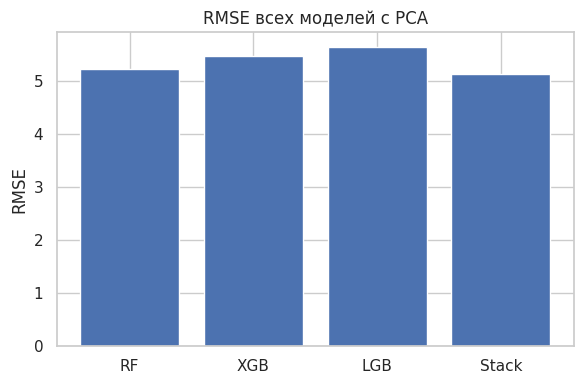

In [26]:
# 0) Устанавливаем нужные библиотеки
!pip install catboost xgboost lightgbm --quiet

# 1) Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 2) Загрузка и удаление утечки
df = pd.read_csv('/content/dataset_for_SI_clean.csv')
leak_cols = [c for c in df.columns if 'IC50' in c.upper() or 'CS50' in c.upper()]
print("Удаляем утечки:", leak_cols)
X = df.drop(columns=['SI'] + leak_cols, errors='ignore')
y = df['SI']

# 3) Сплит
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) Общая функция оценки
def eval_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"{name:25s} RMSE={rmse:.3f}, R2={r2:.3f}, MAE={mae:.3f}")

# 5) Базовый конвейер с PCA → SelectKBest → RF
pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=15, random_state=42)),
    ('select', SelectKBest(f_regression, k=10)),
    ('rf', RandomForestRegressor(
         n_estimators=200, max_depth=15, random_state=42, n_jobs=-1
    ))
])
pipe_rf.fit(X_train, y_train)
pred_rf = pipe_rf.predict(X_test)
eval_model("RF + PCA + SelectKBest", y_test, pred_rf)

# 6) XGBoost с PCA
pipe_xgb = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=15, random_state=42)),
    ('xgb', XGBRegressor(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        random_state=42, verbosity=0
    ))
])
pipe_xgb.fit(X_train, y_train)
pred_xgb = pipe_xgb.predict(X_test)
eval_model("XGBoost + PCA", y_test, pred_xgb)

# 7) LightGBM с PCA
pipe_lgb = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=15, random_state=42)),
    ('lgb', LGBMRegressor(random_state=42, n_jobs=-1))
])
pipe_lgb.fit(X_train, y_train)
pred_lgb = pipe_lgb.predict(X_test)
eval_model("LightGBM + PCA", y_test, pred_lgb)

# 8) Стэкинг (RF + XGB) — тоже через PCA
stack = StackingRegressor(
    estimators=[
        ('rf', pipe_rf),
        ('xgb', pipe_xgb)
    ],
    final_estimator=LinearRegression(),
    n_jobs=-1
)
stack.fit(X_train, y_train)
pred_stack = stack.predict(X_test)
eval_model("Stacking (RF+XGB) + PCA", y_test, pred_stack)

# 9) Сравнение RMSE всех моделей
names = ["RF", "XGB", "LGB", "Stack"]
rmses = [
    np.sqrt(mean_squared_error(y_test, pred_rf)),
    np.sqrt(mean_squared_error(y_test, pred_xgb)),
    np.sqrt(mean_squared_error(y_test, pred_lgb)),
    np.sqrt(mean_squared_error(y_test, pred_stack)),
]

plt.figure(figsize=(6,4))
plt.bar(names, rmses)
plt.ylabel('RMSE')
plt.title('RMSE всех моделей с PCA')
plt.tight_layout()
plt.show()


In [27]:

import pandas as pd
import numpy as np

#  для итеративного удаления выбросов по SI
def remove_all_outliers(df, target_col='SI', k=1.5):
    df = df.copy()
    while True:
        q1 = df[target_col].quantile(0.25)
        q3 = df[target_col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        mask = df[target_col].between(lower, upper)
        if mask.all():
            break
        df = df[mask]
    print(f"After outlier removal: {len(df)} rows; bounds = [{lower:.3f}, {upper:.3f}]")
    return df


#  удаляем «утечки»
df_full = pd.read_csv('/content/dataset_for_SI_clean.csv')
leak_cols = [c for c in df_full.columns if 'IC50' in c.upper() or 'CS50' in c.upper()]
Xy = df_full.drop(columns=leak_cols, errors='ignore')  # оставляем SI
print("Initial shape:", Xy.shape)


#  выбросы по SI
df_si = remove_all_outliers(Xy, 'SI')


df_si.to_csv('/content/dataset_for_SI_2.csv', index=False)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X = df_si.drop(columns=['SI'])
y = df_si['SI']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])
pipe_cb = Pipeline([
    ('scale', StandardScaler()),
    ('cb', CatBoostRegressor(verbose=0, random_state=42))
])

pipe_rf.fit(X_train, y_train)
pipe_cb.fit(X_train, y_train)

for name, model in [('RF (588 rows)', pipe_rf), ('CatBoost (588 rows)', pipe_cb)]:
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    r2   = r2_score(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    print(f"{name:20s} RMSE={rmse:.3f}, R2={r2:.3f}, MAE={mae:.3f}")


Initial shape: (635, 146)
After outlier removal: 514 rows; bounds = [-3.225, 9.214]
RF (588 rows)        RMSE=2.195, R2=0.099, MAE=1.680
CatBoost (588 rows)  RMSE=2.278, R2=0.030, MAE=1.722
